<a href="https://colab.research.google.com/github/Shaheen1998/mypublic/blob/main/mtrq_performence_test_model_drone_dataset__segformer_b5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Unzip Dataset**
Dataset,  
Pretrained Model define,        
Optimizer define

In [ ]:
!unzip /content/drive/MyDrive/Thesis_Code_msee/drone_dataset.zip

Archive:  /content/drive/MyDrive/Thesis_Code_msee/drone_dataset.zip
   creating: drone_dataset/
   creating: drone_dataset/images/
   creating: drone_dataset/images/train/
  inflating: drone_dataset/images/train/102_3.jpg  
  inflating: drone_dataset/images/train/102_4.jpg  
  inflating: drone_dataset/images/train/102_5.jpg  
  inflating: drone_dataset/images/train/163_2.jpg  
  inflating: drone_dataset/images/train/163_3.jpg  
  inflating: drone_dataset/images/train/163_5.jpg  
  inflating: drone_dataset/images/train/163_6.jpg  
  inflating: drone_dataset/images/train/153_1.jpg  
  inflating: drone_dataset/images/train/153_2.jpg  
  inflating: drone_dataset/images/train/153_3.jpg  
  inflating: drone_dataset/images/train/153_4.jpg  
  inflating: drone_dataset/images/train/248_1.jpg  
  inflating: drone_dataset/images/train/248_3.jpg  
  inflating: drone_dataset/images/train/040_1.jpg  
  inflating: drone_dataset/images/train/040_3.jpg  
  inflating: drone_dataset/images/train/040_5.jp

In [ ]:
!pip install --upgrade transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 14.9 MB/s 
     |████████████████████████████████| 163 kB 76.0 MB/s 
     |████████████████████████████████| 6.6 MB 47.2 MB/s 


In [ ]:
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import os
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
import pandas as pd
import cv2
import numpy as np
import albumentations as aug

In [ ]:
WIDTH = 512
HEIGHT = 512

In [ ]:
class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, root_dir, feature_extractor, transforms=None, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.train = train
        self.transforms = transforms

        sub_path = "train" if self.train else "test"
        self.img_dir = os.path.join(self.root_dir, "images", sub_path)
        self.ann_dir = os.path.join(self.root_dir, "mask", sub_path)
        
        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
            image_file_names.extend(files)
        self.images = sorted(image_file_names)
        
        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
            annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        
        image = cv2.imread(os.path.join(self.img_dir, self.images[idx]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        segmentation_map = cv2.imread(os.path.join(self.ann_dir, self.annotations[idx]))
        segmentation_map = cv2.cvtColor(segmentation_map, cv2.COLOR_BGR2GRAY)
        
#         image = Image.open()
#         segmentation_map = Image.open()

        if self.transforms is not None:
            augmented = self.transforms(image=image, mask=segmentation_map)
            # randomly crop + pad both image and segmentation map to same size
            encoded_inputs = self.feature_extractor(augmented['image'], augmented['mask'], return_tensors="pt")
        else:
            encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
            encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

In [ ]:
transform = aug.Compose([
    aug.Flip(p=0.5)
])

In [ ]:
root_dir = '/content/drone_dataset'
feature_extractor = SegformerFeatureExtractor(align=False, reduce_zero_label=False)

train_dataset = ImageSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, transforms=transform)
valid_dataset = ImageSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, transforms=None, train=False)

print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 2100
Number of validation examples: 300


In [ ]:
encoded_inputs = train_dataset[0]

print("encoded_inputs pixel_values shape=  ", encoded_inputs["pixel_values"].shape)
print("encoded_inputs labels shape=  ", encoded_inputs["labels"].shape)
print("encoded_inputs labels=  ", encoded_inputs["labels"])
encoded_inputs["labels"].squeeze().unique()


encoded_inputs pixel_values shape=   torch.Size([3, 512, 512])
encoded_inputs labels shape=   torch.Size([512, 512])
encoded_inputs labels=   tensor([[0, 1, 1,  ..., 1, 1, 1],
        [0, 1, 1,  ..., 1, 1, 1],
        [0, 1, 1,  ..., 1, 1, 1],
        ...,
        [0, 8, 8,  ..., 1, 1, 1],
        [0, 8, 8,  ..., 1, 1, 1],
        [0, 8, 8,  ..., 1, 1, 1]])


tensor([ 0,  1,  2,  4,  8, 15, 22])

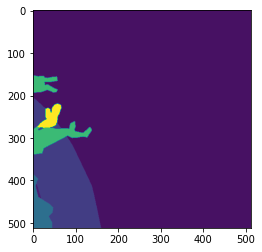

In [ ]:
import matplotlib.pyplot as plt

mask = encoded_inputs["labels"].numpy()
plt.imshow(mask)



In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=4)

batch = next(iter(train_dataloader))

for k,v in batch.items():
    print(k, v.shape)

batch["labels"].shape

pixel_values torch.Size([4, 3, 512, 512])
labels torch.Size([4, 512, 512])


torch.Size([4, 512, 512])

In [ ]:

classes = pd.read_csv('/content/drive/MyDrive/Thesis_Code_mtrq/Segformer/drone_dataset/class_dict_seg.csv')['name']
id2label = classes.to_dict()
label2id = {v: k for k, v in id2label.items()}

In [ ]:
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b5", ignore_mismatched_sizes=True,
                                                         num_labels=len(id2label), id2label=id2label, label2id=label2id,
                                                         reshape_last_stage=True)

Downloading:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/328M [00:00<?, ?B/s]

Some weights of the model checkpoint at nvidia/mit-b5 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.linear_c.0.proj.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.running_mean', 'decode_head.batch_nor

In [ ]:
optimizer = AdamW(model.parameters(), lr=0.00006)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Model Initialized!")

Model Initialized!


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


# Hugging Face Inference 🤗
Load Finetuned Model,  
Apply on Test images

In [ ]:
import os
import pandas as pd
import cv2
import numpy as np
import torch
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor

from PIL import Image
import matplotlib.pyplot as plt
from torch import nn
import math

In [ ]:

df = pd.read_csv('/content/drive/MyDrive/Thesis_Code_mtrq/Segformer/drone_dataset/class_dict_seg.csv')
classes = df['name']
palette = df[[' r', ' g', ' b']].values
id2label = classes.to_dict()
label2id = {v: k for k, v in id2label.items()}

In [ ]:
root_dir = '/content/drone_dataset'
feature_extractor = SegformerFeatureExtractor(align=False, reduce_zero_label=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SegformerForSemanticSegmentation.from_pretrained("deep-learning-analytics/segformer_semantic_segmentation", ignore_mismatched_sizes=True,
                                                         num_labels=len(id2label), id2label=id2label, label2id=label2id,
                                                         reshape_last_stage=True)
model = model.to(device)

Downloading:   0%|          | 0.00/1.94k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/339M [00:00<?, ?B/s]

In [ ]:
# Load our Saved Model and test it

#filepath="/content/drive/MyDrive/Thesis_Code_mtrq/Segformer/Saved_Trained_Models/Augmnt_drone_dataset_Tmodel_11epoc/drone_dataset_Tmodel_2epoc.pt"

filepath="/content/drive/MyDrive/Thesis_Code_mtrq/Segformer/Saved_Trained_Models/Train_segformer_LoveAD_11epoc/LoveAD_images_state_dict_model_24epoc.pt"
state = torch.load(filepath, map_location ='cpu')

model.load_state_dict(state['state_dict'])
optimizer.load_state_dict(state['optimizer'])


model.eval()

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

(2000, 2000, 3)
(2000, 2000)


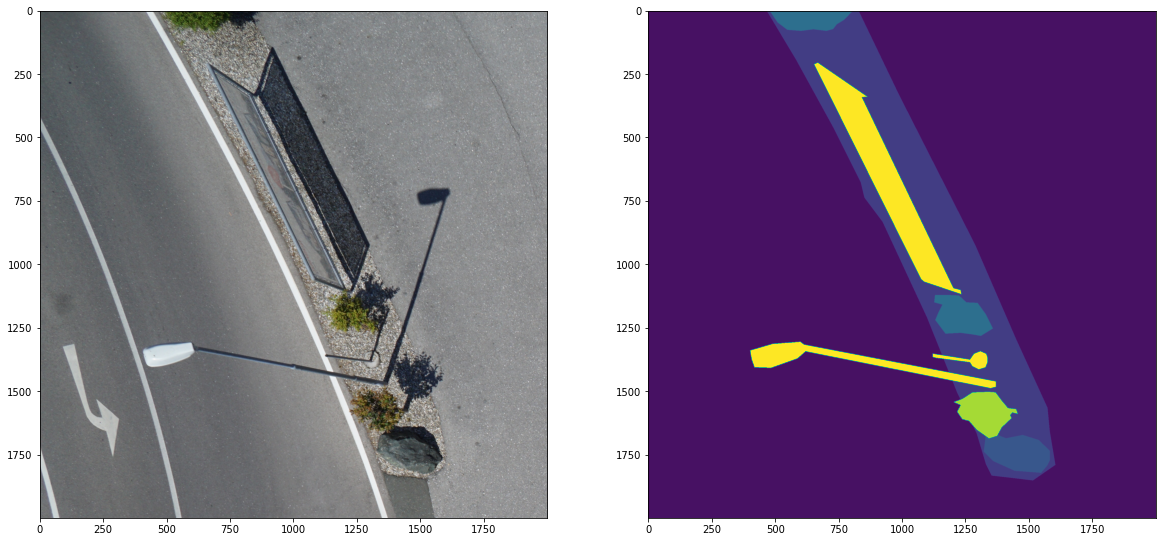

In [ ]:
image = cv2.imread('/content/drone_dataset/images/test/526_1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread('/content/drone_dataset/mask/test/526_1.png',0)

print(image.shape)
print(mask.shape)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(image)
axs[1].imshow(mask)
plt.show()


In [ ]:
# prepare the image for the model (aligned resize)
feature_extractor_inference = SegformerFeatureExtractor(do_random_crop=False, do_pad=False)
pixel_values = feature_extractor_inference(image, return_tensors="pt").pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [ ]:
outputs = model(pixel_values=pixel_values)# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 24, 128, 128])


(2000, 2000, 3)
(2000, 2000)
(2000, 2000, 3)
torch.Size([2000, 2000])
(2000, 2000, 3)


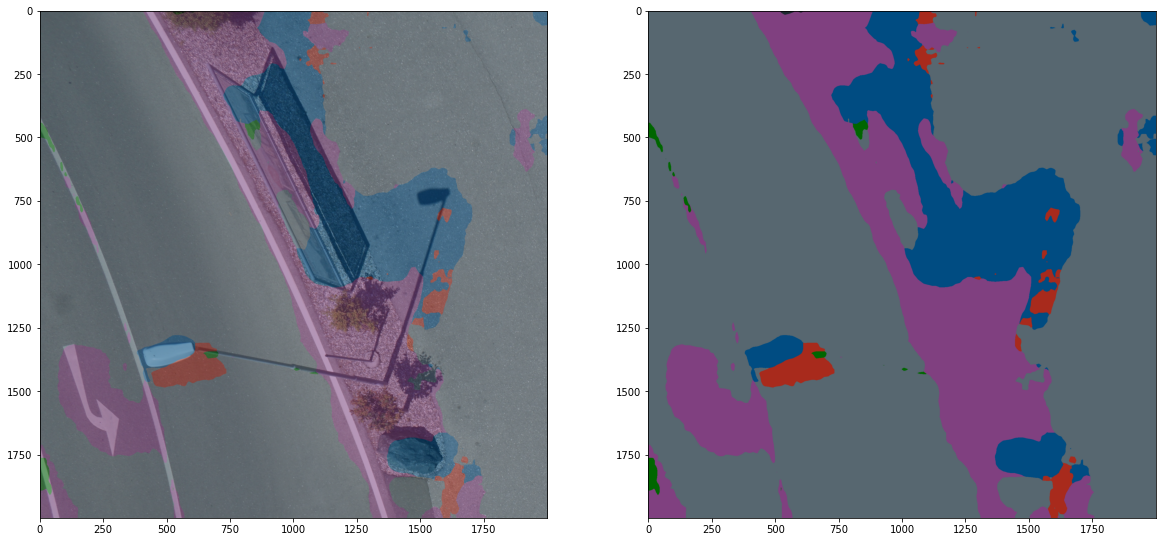

In [ ]:
image = np.array(image)
# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(logits,
                size=image.shape[:-1], # (height, width)
                mode='bilinear',
                align_corners=False)

# Second, apply argmax on the class dimension
seg = upsampled_logits.argmax(dim=1)[0]
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3\
for label, color in enumerate(palette):
    color_seg[seg == label, :] = color

# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

print(image.shape)
print(mask.shape)
print(img.shape)
print(seg.shape)
print(color_seg.shape)


fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(img)
axs[1].imshow(color_seg)
plt.show()

# **Performence measurements **

(2000, 2000)
(2000, 2000)


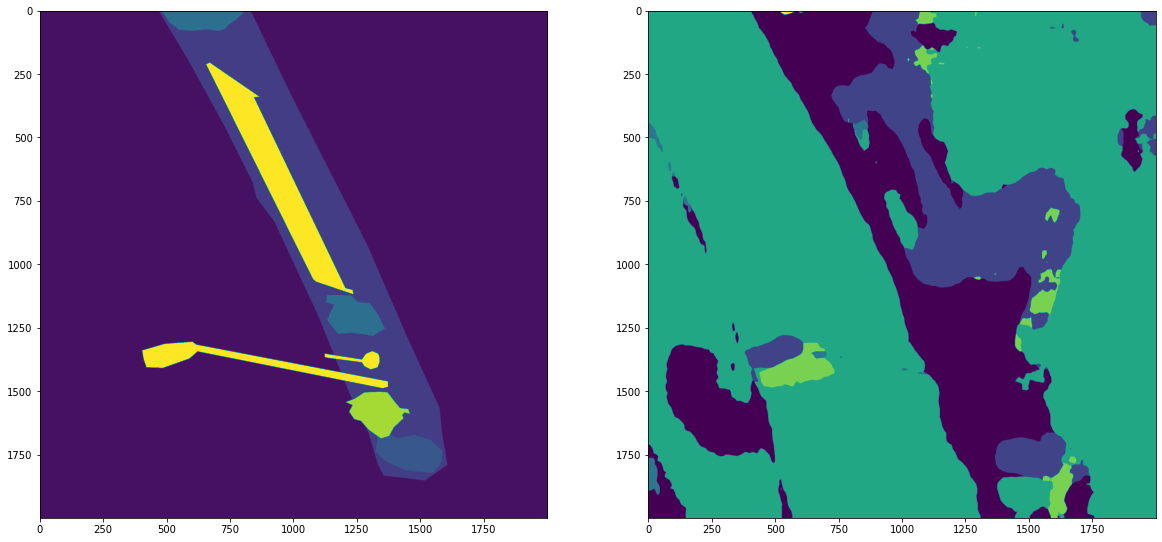

In [ ]:
# image= original image loaded
# mask= True label  =>>>  cv2.imread(path, 0)          =>>> numpy
# seg= Predicted mask with one chanel color (2000, 2000) ........=>>> tensor ........=>>> seg1   tensor to Numpy
# color_seg= Predicted mask with 3channel rgb (2000, 2000, 3)........=>>> tensor ........=>>> color_seg1   tensor to Numpy

#mask = cv2.imread('/content/drone_dataset/mask/test/526_1.png')

seg1=seg.numpy()
print(mask.shape)
print(seg1.shape)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(mask)
axs[1].imshow(seg1)
plt.show()


# **Mean_IOU**
Compute Metric

In [ ]:
!pip install -q transformers datasets

In [ ]:
from datasets import load_metric
metric = load_metric("mean_iou")
map=mask
# metric expects a list of numpy arrays for both predictions and references
metrics = metric.compute(predictions=[seg.numpy()], references=[map], num_labels=150, ignore_index=255)
metrics.keys()

/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342/mean_iou.py:258: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342/mean_iou.py:259: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label


dict_keys(['mean_iou', 'mean_accuracy', 'overall_accuracy', 'per_category_iou', 'per_category_accuracy'])

In [ ]:
print(type(seg))
print(type(map))

<class 'torch.Tensor'>
<class 'numpy.ndarray'>


In [ ]:
classes_map = np.unique(map).tolist()
unique_classes = [model.config.id2label[idx] if idx!=255 else None for idx in classes_map]
print("Classes in this image:", unique_classes)

Classes in this image: ['unlabeled', 'paved-area', 'gravel', 'rocks', 'vegetation', 'tree', 'obstacle']


In [ ]:
import pandas as pd

# print overall metrics
for key in list(metrics.keys())[:3]:
  print(key, metrics[key])

# pretty-print per category metrics as Pandas DataFrame
metric_table = dict()
for id, label in id2label.items():
    metric_table[label] = [
                           metrics["per_category_iou"][id],
                           metrics["per_category_accuracy"][id]
    ]

print("---------------------")
print("per-category metrics:")
pd.DataFrame.from_dict(metric_table, orient="index", columns=["IoU", "accuracy"])

mean_iou 0.010511336163538876
mean_accuracy 0.01797659629298857
overall_accuracy 0.09840625
---------------------
per-category metrics:


,IoU,accuracy
unlabeled,0.000000,0.000000
paved-area,0.103915,0.116143
dirt,0.000000,NaN
grass,0.000000,NaN
gravel,0.001199,0.009693
water,0.000000,NaN
rocks,0.000000,0.000000
pool,NaN,NaN
vegetation,0.000000,0.000000
roof,NaN,NaN


# **Mean_IOU_whole Val**

In [ ]:
import glob
from datasets import load_metric
!pip install -q transformers datasets
metric = load_metric("mean_iou")

True_mask = []
Predicted_mask_seg= []

Mean_iou_all_val=[]
Mean_Accuracy_all_val=[]

val_images_dir= "/content/drone_dataset/images/test/*.jpg"
val_annotations_dir= "/content/drone_dataset/mask/test/*.png"

for imgw in glob.glob(val_images_dir):
    True_mask.append(imgw)
val_images = sorted(True_mask)

for img in glob.glob(val_annotations_dir):
    Predicted_mask_seg.append(img)
val_annotations = sorted(Predicted_mask_seg)



for i in range(len(val_images)-150):

  image=cv2.imread(val_images[i])
  feature_extractor_inference = SegformerFeatureExtractor(do_random_crop=False, do_pad=False)
  pixel_values = feature_extractor_inference(image, return_tensors="pt").pixel_values.to(device)

  
  outputs = model(pixel_values=pixel_values)# logits are of shape (batch_size, num_labels, height/4, width/4)
  logits = outputs.logits.cpu()

   
  image = np.array(image)
  # First, rescale logits to original image size
  upsampled_logits = nn.functional.interpolate(logits,
                  size=image.shape[:-1], # (height, width)
                  mode='bilinear',
                  align_corners=False)
    
  # Second, apply argmax on the class dimension
  seg = upsampled_logits.argmax(dim=1)[0]


  
  map=cv2.imread(val_annotations[i], 0)

  
  # metric expects a list of numpy arrays for both predictions and references
  metrics = metric.compute(predictions=[seg.numpy()], references=[map], num_labels=150, ignore_index=255)
  metrics.keys()
  
  Mean_iou_all_val.append(metrics["mean_iou"])
  Mean_Accuracy_all_val.append(metrics["mean_accuracy"])

  #print("\nMean_iou:", metrics["mean_iou"])
  #print("Mean accuracy:", metrics["mean_accuracy"])






print("\n Mean_iou_all_val=   ", Mean_iou_all_val )
print(" Mean_Accuracy_all_val=  ", Mean_Accuracy_all_val)
print(" Average_Mean_iou_all_val=   ", np.mean(Mean_iou_all_val) )
print(" Average_Mean_Accuracy_all_val=  ", np.mean(Mean_Accuracy_all_val) )




tt= np.mean(Mean_iou_all_val)
tt1=np.mean(Mean_Accuracy_all_val)
t=np.array([tt, tt1])

# using the savetxt 
# from the numpy module
np.savetxt("/content/drive/MyDrive/Thesis_Code_mtrq/Segformer/Saved_Trained_Models/Train_segformer_LoveAD_11epoc/Performence_Metrix_drone_dataset_Tmodel_2epoc/Mean_iou_all_val.csv", 
           Mean_iou_all_val,
           delimiter =", ", 
           fmt ='% s')


np.savetxt("/content/drive/MyDrive/Thesis_Code_mtrq/Segformer/Saved_Trained_Models/Train_segformer_LoveAD_11epoc/Performence_Metrix_drone_dataset_Tmodel_2epoc/Mean_Accuracy_all_val.csv", 
           Mean_Accuracy_all_val,
           delimiter =", ", 
           fmt ='% s')


np.savetxt("/content/drive/MyDrive/Thesis_Code_mtrq/Segformer/Saved_Trained_Models/Train_segformer_LoveAD_11epoc/Performence_Metrix_drone_dataset_Tmodel_2epoc/1Average_Mean_iou_all__2Average_Accuracy_val.csv", 
           t,
           delimiter =", ", 
           fmt ='% s')

  
  

/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342/mean_iou.py:258: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342/mean_iou.py:259: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label
/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342/mean_iou.py:258: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342/mean_iou.py:259: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / t


 Mean_iou_all_val=    [0.01703267269056307, 0.013332733150184276, 0.016548226177045967, 0.00629625276808978, 0.047129145994855154, 0.02194817127121207, 0.0011868849216161417, 0.005431321516218903, 0.06859772738594865, 0.007339509931377227, 5.469121054676818e-05, 0.004233267414237795, 2.1596710167196183e-05, 0.0, 0.0, 0.005137202447996112, 0.0, 0.0, 0.034228976024667006, 0.027569412729448087, 0.019181532118463372, 0.039423023230372875, 0.019729124218894552, 0.016805099109351487, 0.07778383335063496, 0.07017953257585542, 0.00969569488452522, 0.05422642932346132, 0.07039635023766047, 0.0996191583488165, 0.010489791384124113, 0.0063407711502931775, 0.002964447546754354, 0.007540202859964345, 6.673829070393534e-05, 0.005178743422852575, 0.01348354084572491, 0.03423007034257729, 0.04022628631313087, 0.051598295682299206, 0.06155015753931161, 0.006851981634062828, 0.02830262140304145, 0.014093181556143225, 0.02630980470371628, 0.014765237703399586, 0.019886740533082228, 0.01516744626412313, 

/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/d4add40cf977cdd73590b5873fa830f3f13adb678f6777a29fb07b7c81d14342/mean_iou.py:251: RuntimeWarning: invalid value encountered in true_divide
  results, gt_seg_maps, num_labels, ignore_index, label_map, reduce_labels


FileNotFoundError: ignored

In [ ]:
tt= np.mean(Mean_iou_all_val)
tt1=np.mean(Mean_Accuracy_all_val)
t=np.array([tt, tt1])
t

array([0.40156404, 0.55164737])

In [ ]:
# using the savetxt 
# from the numpy module
np.savetxt("/content/drive/MyDrive/Thesis_Code_mtrq/Segformer/Saved_Trained_Models/Train_segformer_LoveAD_11epoc/Performence_Metrix_drone_dataset_Tmodel_2epoc/Mean_iou_all_val.csv", 
           Mean_iou_all_val,
           delimiter =", ", 
           fmt ='% s')


np.savetxt("/content/drive/MyDrive/Thesis_Code_mtrq/Segformer/Saved_Trained_Models/Train_segformer_LoveAD_11epoc/Performence_Metrix_drone_dataset_Tmodel_2epoc/Mean_Accuracy_all_val.csv", 
           Mean_Accuracy_all_val,
           delimiter =", ", 
           fmt ='% s')


np.savetxt("/content/drive/MyDrive/Thesis_Code_mtrq/Segformer/Saved_Trained_Models/Train_segformer_LoveAD_11epoc/Performence_Metrix_drone_dataset_Tmodel_2epoc/1Average_Mean_iou_all__2Average_Accuracy_val.csv", 
           t,
           delimiter =", ", 
           fmt ='% s')


In [ ]:
print(len(val_images))

print(range(len(val_images)-1))

300
range(0, 299)


# **Dice Coefficient**

Dice Score 8.867049734513195
Dice Score 8.867049734513195

type(seg1) <class 'numpy.ndarray'>
type(mask) <class 'numpy.ndarray'>

mask.shape (2000, 2000)
seg1.shape (2000, 2000)


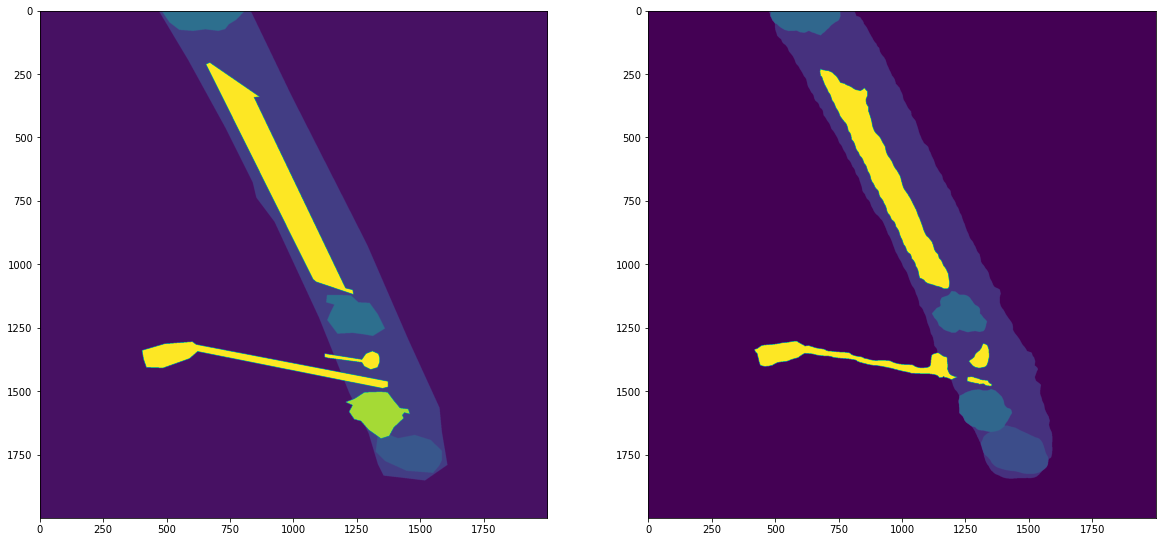

In [ ]:
# Test on Dimention (2000, 2000)

import numpy as np
def single_dice_coef(y_true, y_pred_bin):
    # shape of y_true and y_pred_bin: (height, width)
    intersection = np.sum(y_true * y_pred_bin)
    if (np.sum(y_true)==0) and (np.sum(y_pred_bin)==0):
        return 1
    return (2*intersection) / (np.sum(y_true) + np.sum(y_pred_bin))


def dice_coef2(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union==0: return 1
    intersection = np.sum(y_true_f * y_pred_f)
    return 2. * intersection / union


seg1=seg.numpy()
d=single_dice_coef(mask,seg1)
d1=dice_coef2(mask,seg1)
print("Dice Score", d)
print("Dice Score", d1)

print("\ntype(seg1)", type(seg1))
print("type(mask)", type(mask))

print("\nmask.shape", mask.shape)
print("seg1.shape", seg1.shape)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(mask)
axs[1].imshow(seg1)
plt.show()





True_mask_3D=   torch.Size([2000, 2000, 3])
Predicted_mask_3D=   torch.Size([2000, 2000, 3])


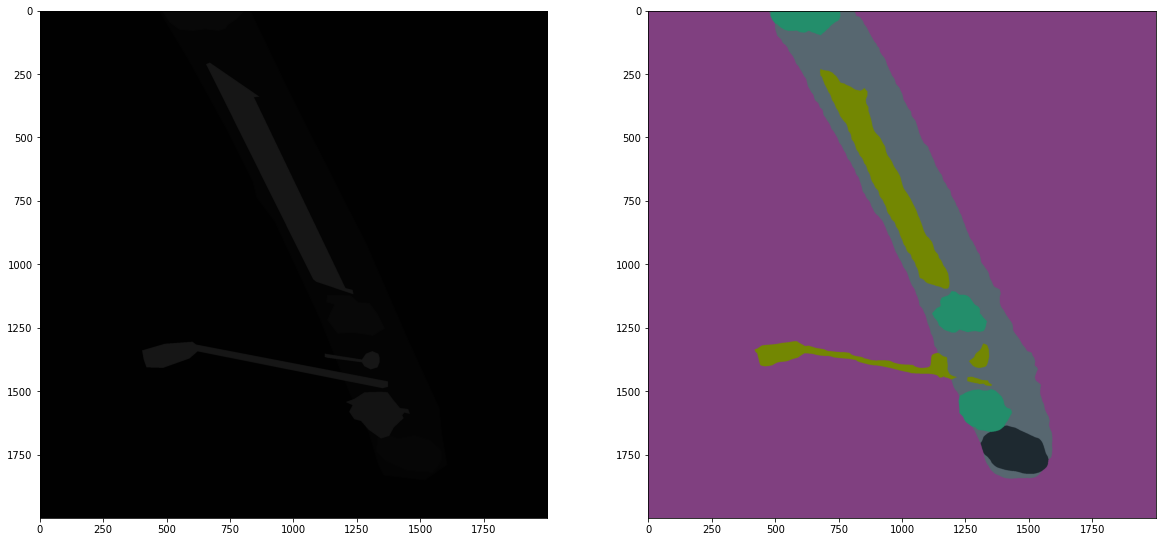

In [ ]:
# Convert into tensors with size (2000, 2000, 3)

seg1=seg.numpy()
mask1 = cv2.imread('/content/drone_dataset/mask/test/526_1.png')

True_mask_3D = torch.from_numpy(mask1)
Predicted_mask_3D = torch.from_numpy(color_seg.copy())
print("True_mask_3D=  ", True_mask_3D.shape)
print("Predicted_mask_3D=  ", Predicted_mask_3D.shape)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(True_mask_3D)
axs[1].imshow(Predicted_mask_3D)
plt.show()

True_mask_1D (2000, 2000)
True_color_mask_3D=    (2000, 2000, 3)


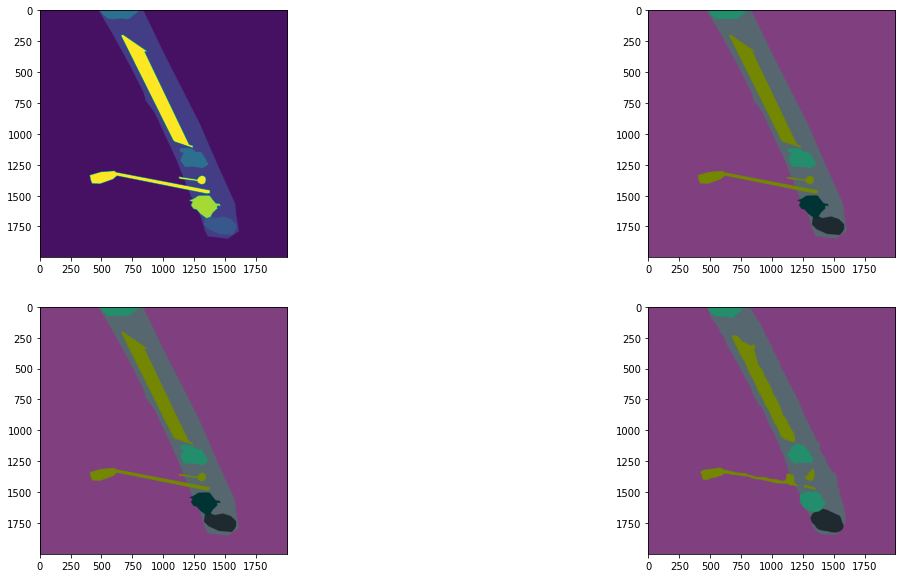

In [ ]:
# Colour True mask and color predicted mask from 1D

# Convert true mask into color rgb
image1 = np.array(mask)
color_seg2 = np.zeros((image1.shape[0], image1.shape[1], 3), dtype=np.uint8) # height, width, 3\
for label, color in enumerate(palette):
    color_seg2[image1 == label, :] = color

# Convert to BGR
True_color_mask_3D = color_seg2[..., ::-1]


print("True_mask_1D", image1.shape)
print("True_color_mask_3D=   ", True_color_mask_3D.shape)


fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs[0][0].imshow(image1)
axs[0][1].imshow(True_color_mask_3D)
axs[1][0].imshow(True_color_mask_3D)
axs[1][1].imshow(color_seg)
plt.show()

IOU

In [ ]:
import torch
import numpy as np 


# PyTroch version

SMOOTH = 1e-6

def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded, iou  # Or thresholded.mean() if you are interested in average across the batch
    
''' 
# Numpy version
# Well, it's the same function, so I'm going to omit the comments

def iou_numpy(outputs: np.array, labels: np.array):
    outputs = outputs.squeeze(1)
    
    intersection = (outputs & labels).sum((1, 2))
    union = (outputs | labels).sum((1, 2))
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    
    thresholded = np.ceil(np.clip(20 * (iou - 0.5), 0, 10)) / 10
    
    return thresholded, iou  # Or thresholded.mean()
'''

True_color_mask_3Dt = torch.from_numpy(True_color_mask_3D.copy())
Predicted_color_mask_3Dt = torch.from_numpy(color_seg.copy())
print(type(True_color_mask_3Dt))
print(type(Predicted_color_mask_3Dt))

# For Numpy
#d, d1=iou_numpy(True_color_mask_3D,color_seg)
#print("\nDice Score", d1)

# For Tensores

d, d1=iou_pytorch(True_color_mask_3Dt,Predicted_color_mask_3Dt)
print("\nDice Score", d1)
print(len(d1))
print(type(d1))

print(torch.mean(d1))

<class 'torch.Tensor'>
<class 'torch.Tensor'>

Dice Score tensor([0.1353, 0.1359, 0.1366,  ..., 0.9975, 0.9975, 0.9975])
2000
<class 'torch.Tensor'>
tensor(0.9658)


In [ ]:
# Test on tensors with tensor  dimention (2000, 2000, 3)
print("True_color_mask_3D", True_color_mask_3D.shape)
print("Predicted_color_mask_3D=   ", color_seg.shape)
print(type(True_color_mask_3D))
print(type(color_seg))
# For Numpy
d=single_dice_coef(True_color_mask_3D,color_seg)
print("\nDice Score", d)

# For Tensores
True_color_mask_3Dt = torch.from_numpy(True_color_mask_3D.copy())
Predicted_color_mask_3Dt = torch.from_numpy(color_seg.copy())
print(type(True_color_mask_3Dt))
print(type(Predicted_color_mask_3Dt))
d=iou_pytorch(True_color_mask_3Dt,Predicted_color_mask_3Dt)
print("\nDice Score", d)

True_color_mask_3D (2000, 2000, 3)
Predicted_color_mask_3D=    (2000, 2000, 3)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>

Dice Score 0.1431686086449412
<class 'torch.Tensor'>
<class 'torch.Tensor'>

Dice Score (tensor([0., 0., 0.,  ..., 1., 1., 1.]), tensor([0.1353, 0.1359, 0.1366,  ..., 0.9975, 0.9975, 0.9975]))


In [ ]:
d=single_dice_coef(True_color_mask_3D,color_seg)
d1=dice_coef2(True_color_mask_3D,color_seg)
print("Dice Score", d)
print("Dice Score", d1)

Dice Score 0.1431686086449412
Dice Score 0.1431686086449412


# **Nexr**

In [ ]:
img.shape

(1024, 1024, 3)

In [ ]:
def crop_augment(img):
    HEIGHT, WIDTH = 2000, 2000

    vertical = math.ceil(img.shape[0] / HEIGHT)
    horizontal = math.ceil(img.shape[1] / WIDTH)
    start_v = 0
    count = 1
    data = {'images': [],
            'horizontal': horizontal,
            'vertical': vertical}
    for v in range(vertical):
        start_h = 0
        for h in range(horizontal):
            if start_h + WIDTH > img.shape[1]:
                start_h = start_h - ((start_h + WIDTH) - img.shape[1])
            if start_v + HEIGHT > img.shape[0]:
                start_v = start_v - ((start_v + HEIGHT) - img.shape[0])
            crop = img[start_v:start_v+HEIGHT, start_h:start_h+WIDTH]
            data['images'].append(crop)
            count += 1
            start_h += WIDTH
        start_v += HEIGHT

    return data

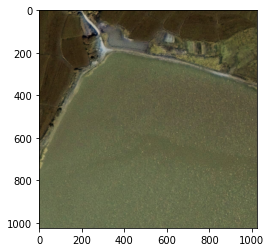

In [ ]:
image1 = Image.open('/content/drive/MyDrive/Thesis_Code/Segformer/ADE20k_toy_dataset_my_data_stlite/images/validation/2524.png')
images1 = np.array(image1)
image = cv2.cvtColor(images1, cv2.COLOR_BGR2RGB)

data = crop_augment(image)
plt.imshow(image)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Thesis_Code/Segformer/drone_dataset/class_dict_seg.csv')
classes = df['name']
palette = df[[' r', ' g', ' b']].values
id2label = classes.to_dict()
label2id = {v: k for k, v in id2label.items()}

In [ ]:
root_dir = '/content/drive/MyDrive/test/ADE20k_toy_dataset_my_data_stlite'
feature_extractor = SegformerFeatureExtractor(align=False, reduce_zero_label=False)
device = torch.device("cpu")
model = SegformerForSemanticSegmentation.from_pretrained("deep-learning-analytics/segformer_semantic_segmentation", ignore_mismatched_sizes=True,
                                                         num_labels=len(id2label), id2label=id2label, label2id=label2id,
                                                         reshape_last_stage=True)
model = model.to(device)

In [ ]:
# prepare the image for the model (aligned resize)
feature_extractor_inference = SegformerFeatureExtractor(do_random_crop=False, do_pad=False)
images = []
for img in data['images']:
    pixel_values = feature_extractor_inference(img, return_tensors="pt").pixel_values[0].numpy()
    images.append(pixel_values)
pixel_values = torch.tensor(np.array(images)).to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [ ]:
model.eval()
outputs = model(pixel_values=pixel_values)# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 24, 128, 128])
